In [6]:
import pandas as pd
import numpy as np
import json
from Bio import SeqIO
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
#Load tree and sequence files
with open('augur_output/flu_seasonal_h3n2_ha_6y_tree.json', 'r') as jsonfile:
    tree_6y = json.load(jsonfile)

with open('augur_output/flu_seasonal_h3n2_ha_6y_sequences.json', 'r') as jsonfile:
    seq_6y = json.load(jsonfile)

#Load genbank file with reference HA sequence
for seq_record in SeqIO.parse('h3n2_outgroup.gb', 'genbank'):
    SP_ref = seq_record.seq[0:49].translate()
    HA1_ref = seq_record.seq[48:1035].translate()
    HA2_ref = seq_record.seq[1035:1699].translate()

In [131]:
#Input desired 0-based HA1 amino acid residue positions, find reference amino acid

positions = [159]
position_refaa = []

for pos in positions:
    position_refaa.append((str(pos), HA1_ref[pos]))
    
tip_muts = {}

def traverse(branch, seq, pos_list):

    if 'children' not in branch.keys():

        tip_muts[branch['strain']]=[branch['aa_muts']['HA1'], branch['aa_muts']['HA2'], 
                                    branch['aa_muts']['SigPep'],branch['attr']['num_date'], 
                                    branch['attr']['clade_membership']] + [str(seq[str(branch['clade'])]['HA1'][pos]) if pos in seq[str(branch['clade'])]['HA1'] else str(ref_aa) 
                                    for pos, ref_aa in pos_list]

    else:
        for child in branch['children']:
            traverse(child, seq, pos_list)

    
traverse(tree_6y, seq_6y, position_refaa)

#Organize data in a DF
df = pd.DataFrame(tip_muts).T
df.reset_index(inplace=True)
df.columns = ['strain', 'tip_HA1_muts', 'tip_HA2_muts', 'tip_SigPep_muts', 'date', 'clade']+positions
df['passage'] = np.select((df.strain.str.contains('egg'), df.strain.str.contains('cell')), ('egg', 'cell'))
df['source'] = np.select((df.passage=='egg', df.passage=='cell', df.passage=='0'), 
                         (df.strain.str.replace('-egg',''), df.strain.str.replace('-cell',''), df.strain))

#make tidy version of df where each mutation gets a row
mut_df = pd.DataFrame(columns=['mutation']+ list(df.columns))

count=0
for i, r in df.iterrows():

    for ha1_mut in r['tip_HA1_muts']:
        mut_df.loc[count]= ['HA1'+str(ha1_mut)] + list(df.loc[i])
        count+=1
        
    for ha2_mut in r['tip_HA2_muts']:
        mut_df.loc[count]= ['HA2'+str(ha2_mut)] + list(df.loc[i])
        count+=1
        
    for sp_mut in r['tip_SigPep_muts']:
        mut_df.loc[count]= ['SP'+str(sp_mut)] + list(df.loc[i])
        count+=1

In [76]:
#Find predominant 160 genotype of circulating virus by clade
#Use this to determine whether egg-passaged strains have mutated

#df[df.passage=='0'].groupby('clade')[159].value_counts()

circulating_160_clade = {'3b':'K', '3c':'K', '3c2.A':'T', '3c3':'K', 
                         '3c3.A':'K', '3c3.B':'K', 'A1':'T', 'A1a':'T',
                         'A1b':'T', 'A1b/135K':'T', 'A1b/135N':'T', 
                         'A2':'T', 'A2/re':'T', 'A3':'T', 'A4':'T', 'unassigned':'K'}


egg_df = df[df.passage=='egg'].copy()
egg_df['circulating_160'] = egg_df['clade'].map(circulating_160_clade)
egg_df['eggmut_160'] = np.select(
    (egg_df[159]==egg_df['circulating_160'], egg_df[159]!=egg_df['circulating_160']), 
    (False, True))

#Verify method by showing that mutations at 160 only occur when passaged virus is T160
#True with the exception of 1 K-->R, all 533 seqs look right
#egg_df.groupby(['eggmut_160',159])['circulating_160'].value_counts()

In [103]:
#Same as above but with row for each HA1 mutation, so top co-occuring mutations can be identified


circulating_160_clade = {'3b':'K', '3c':'K', '3c2.A':'T', '3c3':'K', 
                         '3c3.A':'K', '3c3.B':'K', 'A1':'T', 'A1a':'T',
                         'A1b':'T', 'A1b/135K':'T', 'A1b/135N':'T', 
                         'A2':'T', 'A2/re':'T', 'A3':'T', 'A4':'T', 'unassigned':'K'}


mut_egg_df = mut_df[mut_df.passage=='egg'].copy()
mut_egg_df['circulating_160'] = mut_egg_df['clade'].map(circulating_160_clade)
mut_egg_df['eggmut_160'] = np.select(
    (mut_egg_df[159]==mut_egg_df['circulating_160'], mut_egg_df[159]!=mut_egg_df['circulating_160']), 
    (False, True))

Text(0,0.5,u'Proportion of egg-passaged viruses that mutated at position 160')

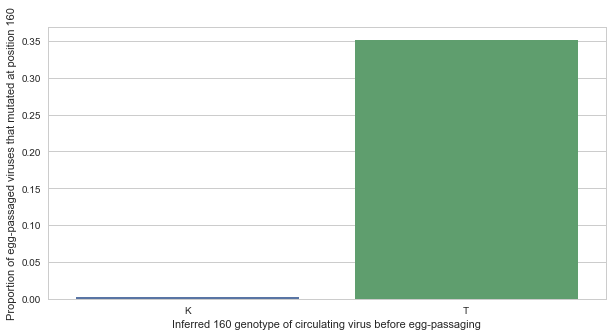

In [91]:
#For unpaired egg sequences (from inferred circulating virus), find number with mutations at 160

sns.set(style='whitegrid')
fig, ax = plt.subplots(figsize=(10,5))
fig = sns.barplot(x='circulating_160', y='eggmut_160', data=egg_df, ci=None, ax=ax)
plt.xlabel('Inferred 160 genotype of circulating virus before egg-passaging')
plt.ylabel('Proportion of egg-passaged viruses that mutated at position 160')

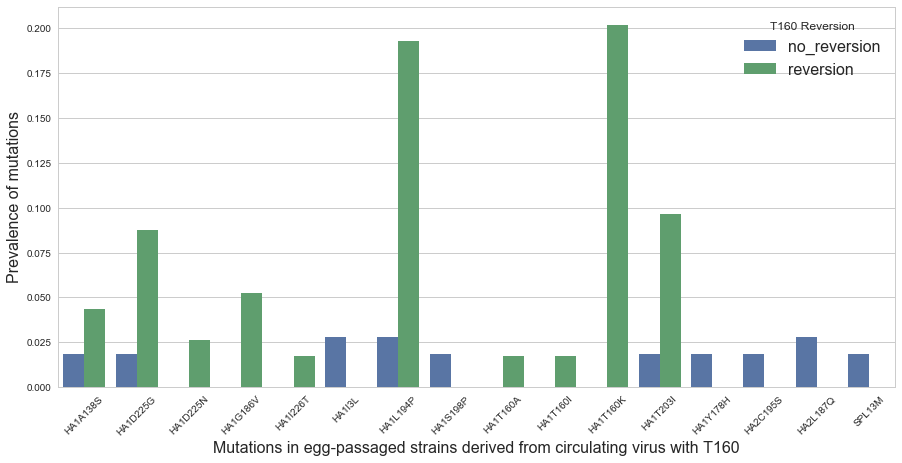

In [234]:
#Find top tip mutations that co-occur with 160 T->K reversion mutation

comuts160 = {}

grouped = mut_egg_df.groupby(['circulating_160', 'eggmut_160'])['mutation']
for g_name, g in grouped:
    if 'T' in g_name:
        comuts160[g_name[1]] = dict(g.value_counts(normalize=True).nlargest(10))
comuts160_df = pd.DataFrame(comuts160).reset_index().rename(
    columns={'index':'co_mut', 0: 'no_reversion', 1: 'reversion'}).melt(
    id_vars='co_mut', value_vars=['no_reversion', 'reversion'], var_name='T160mut', value_name='mut_prev')

fig, ax = plt.subplots(figsize=(15,7))
fig = sns.barplot(x='co_mut', y='mut_prev', hue='T160mut', data=comuts160_df)
plt.xlabel('Mutations in egg-passaged strains derived from circulating virus with T160', fontsize=16)
plt.ylabel('Prevalence of mutations', fontsize=16)
ax.xaxis.set_tick_params(rotation=45)
ax.legend(loc=1, fontsize=16, title='T160 Reversion')


In [108]:
#Find top tip mutations that co-occur with a mutation at HA1-160

top_muts = {}
for mut160 in mut_egg_df['eggmut_160'].unique():
    top = mut_egg_df[mut_egg_df['eggmut_160']==mut160].groupby('mutation')['mutation'].count().sort_values(ascending=False)[:10]
    top_muts[mut160] = list((g_name, g) for g_name, g in top.iteritems())

print(pd.DataFrame(top_muts))

                0               1
0  (HA1G186V, 46)  (HA1T160K, 23)
1  (HA1L194P, 28)  (HA1L194P, 23)
2  (HA1S219F, 16)  (HA1T203I, 11)
3   (HA1S219Y, 9)  (HA1D225G, 10)
4   (HA1H156R, 8)   (HA1G186V, 6)
5   (HA1H156Q, 8)   (HA1A138S, 5)
6   (HA1D225G, 8)   (HA1D225N, 3)
7   (HA1H183L, 7)   (HA1T160I, 2)
8   (HA1N246H, 6)   (HA1T160A, 2)
9     (SPA16T, 5)   (HA1S219Y, 2)
